## South Park Model
Training on the attention "cut-outs" of the pixels for additive generation based on the sequence of texts
Reverse engineering of the image to captioning model

---

### Imports and Configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, colorConverter
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import re

# tensorflow
import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, Conv2DTranspose, Flatten, Layer, Reshape, Input, LeakyReLU, MaxPooling2D, Concatenate, Conv1D, Lambda, BatchNormalization, UpSampling2D, Add, GRU, Embedding
from tensorflow.keras.models import Model


%matplotlib inline

/Users/milk/Desktop/GIL_Lab/BMO/BMO_chatbot_prototype/bmo-venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-05-09 11:50:41.607095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#import from Python folder to get the utils
import sys
sys.path.append('../Python')
from utils import picoSS2np, showMultiSprPalette, showMultiSprRGB, showSprRGB, showSprPalette, animatePal, encodeSpr1H, decodeSpr1H, showTxtEmb

In [3]:
### CONSTANT VARIABLES   ###

# PICO-8 Palette => use colormap for matplotlib
PICO_PALETTE = ['#000000','#1D2B53','#7E2553','#008751','#AB5236','#5F574F','#C2C3C7','#FFF1E8','#FF004D','#FFA300','#FFEC27','#00E436','#29ADFF','#83769C','#FF77A8','#FFCCAA']


Char Dataset shape: (100, 8, 8)
Char Labels shape: (100,)
a man with brown hair and a brown shirt with black pants


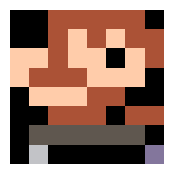

In [4]:
# import from the PICO sprites posted onto Twitter 
# Characters: https://twitter.com/johanvinet/status/635814153601597441
pico_char_dat = np.load('../data/rip_data/pico_characters.npy',allow_pickle=True)

# import the text data
pico_char_labels = np.array([l.strip() for l in open('../data/rip_data/character_desc.txt','r').readlines()])

print(f"Char Dataset shape: {pico_char_dat.shape}")
print(f"Char Labels shape: {pico_char_labels.shape}")

# show a random food and character sprite 
rand_i = random.randint(0,pico_char_dat.shape[0]-1)
rand_char = pico_char_dat[rand_i]
rand_label = pico_char_labels[rand_i]
print(rand_label)
showSprPalette(pico_char_dat[rand_i])

In [5]:
# import sentence-transformer for text embedding 
SBERT_MODEL = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

def sentEmb(txt,MODIFIER=5):
    return SBERT_MODEL.encode([txt])[0]*MODIFIER

# encode the labels
pico_char_emb = []
with tqdm(total=len(pico_char_labels)) as pbar:
    pbar.set_description("Encoding labels")
    for l in pico_char_labels:
        pico_char_emb.append(sentEmb(l))
        pbar.update(1)

pico_char_emb = np.array(pico_char_emb)
print(f"Char Embeddings shape: {pico_char_emb.shape}")

Encoding labels: 100%|██████████| 100/100 [00:01<00:00, 64.46it/s]

Char Embeddings shape: (100, 384)


In [6]:
# import word2vec model from the GLoVe model (for use with individual word embedding)
GLOVE_DAT = {}
with open("../data/glove.6B/glove.6B.50d.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()
    with tqdm(total=len(lines)) as pbar:
        for line in lines:
            line = line.split()
            GLOVE_DAT[line[0]] = np.array([float(x) for x in line[1:]])
            pbar.update(1)

100%|██████████| 400000/400000 [00:05<00:00, 69746.61it/s]


### Initial Spr2Caption Attention model
- Used for training data for the South Park model
- Taken from the tutorial given here: https://towardsdatascience.com/image-captions-with-attention-in-tensorflow-step-by-step-927dad3569fa

In [7]:
# preprocess the labels as a bag of words vocabulary
# prep the captions for tokenizations
vocab = ["<pad>","<start>","<end>","<unk>"]

# preprocess the descriptions
proc_desc = []
long_desc = 0
print("> Preprocessing descriptions for tokenization")
with tqdm(total=len(pico_char_labels)) as pbar:
    for desc in pico_char_labels:
        # remove punctuation with regex
        desc2 = re.sub('[\.\?\,]','',desc)
        desc2 = re.sub('[\-]',' ',desc2)

        # add start and end tokens
        desc3 = "<start> " + desc2 + " <end>"

        # add to vocab for tokenization
        words = desc3.split()
        vocab.extend(words)

        if len(words) > long_desc:
            long_desc = len(words)
        
        proc_desc.append(desc3)
        pbar.update(1)

# create the vocab
vocab, cts = np.unique(vocab, return_counts=True)
FULL_VOCAB = ["<pad>","<start>","<end>","<unk>"]
for v,c in zip(vocab,cts):
    if v in FULL_VOCAB:  #skip already added
        continue
    FULL_VOCAB.append(v)

    # if c > 1:  # only add words that appear more than once
    #     FULL_VOCAB.append(v)

print(f"Vocab size: {len(FULL_VOCAB)}")
print(f"Vocab (1st 10): {FULL_VOCAB[:10]}")
print(f"Longest description: {long_desc}")

# tokenize a description to the vocab one hot
def tok(desc,vocab=FULL_VOCAB,add_start_end=False):
    desc_tok = []
    words = desc.split()
    end = len(words) if len(words) < long_desc else long_desc

    # add start token
    if add_start_end:
        desc_tok.append(vocab.index("<start>"))
    # add vocab index
    for i in range(long_desc):
        # add end if needed
        if i == end and add_start_end:
            desc_tok.append(vocab.index("<end>"))
            continue

        # add the word or padding
        if i < len(desc.split()):
            desc_tok.append(vocab.index(words[i]) if words[i] in vocab else vocab.index("<unk>"))
        else:
            desc_tok.append(0)  # assume <pad> token is 0
    return desc_tok

# untokenize a description based on the vocab
def untok(toks,vocab=FULL_VOCAB):
    desc = ""
    for t in toks:
        if t == 0:
            continue
        desc += vocab[t] + " "
    return desc.strip()

# tokenize the captions
print("> Tokenizing labels")
pico_char_labels_tok = []
with tqdm(total=len(proc_desc)) as pbar2:
    for desc in proc_desc:
        desc_tok = tok(desc)
        pico_char_labels_tok.append(desc_tok)
        pbar2.update(1)
pico_char_labels_tok = np.array(pico_char_labels_tok)
print(f"Label set tokenized: {pico_char_labels_tok.shape}")

ex_i = np.random.randint(0,len(pico_char_labels_tok))
print(f"Example: {pico_char_labels_tok[ex_i]}")
print(f"Example: {untok(pico_char_labels_tok[ex_i])}")


> Preprocessing descriptions for tokenization


100%|██████████| 100/100 [00:00<00:00, 94594.14it/s]


Vocab size: 141
Vocab (1st 10): ['<pad>', '<start>', '<end>', '<unk>', 'a', 'alien', 'an', 'and', 'armor', 'arms']
Longest description: 22
> Tokenizing labels


100%|██████████| 100/100 [00:00<00:00, 22573.08it/s]

Label set tokenized: (100, 22)
Example: [  1   4 134  45 136   4  58  92   7   4  58  63   2   0   0   0   0   0
   0   0   0   0]
Example: <start> a white duck with a green outfit and a green hat <end>


In [8]:
# create the dataset of img-tokens pairs
BATCH_SIZE = 32

def spr2tokDat(sprs, tok_descs,batch_size=16):
    x_dat = []
    y_dat = []
    for spr,desc in zip(sprs,tok_descs):
        spr_flat = encodeSpr1H(spr).reshape(64,16)
        x_dat += [spr_flat]
        y_dat += [desc]

    # create a tensorflow dataset
    x_dat = np.array(x_dat)
    y_dat = np.array(y_dat)

    dataset = tf.data.Dataset.from_tensor_slices((x_dat,y_dat))
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

attn_spr_dataset = spr2tokDat(pico_char_dat,pico_char_labels_tok,batch_size=BATCH_SIZE)

2023-05-09 11:50:55.663478: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# create the attention layer/model
class Attention_B2(tf.keras.Model):
    def __init__(self,units):
        super(Attention_B2,self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self,features,hidden):
        hidden_w_time_axis = tf.expand_dims(hidden,1)  
        attn_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_w_time_axis)))
        score = self.V(attn_hidden_layer)

        attention_weights = tf.nn.softmax(score,axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector,axis=1)

        return context_vector, attention_weights
    
# encoder layer for the image
class Encoder_B2(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder_B2,self).__init__()
        self.fc = tf.keras.layers.Dense(embed_dim)

    def call(self,x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x
    
# decoder using the attention
class Decoder_B2(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder_B2, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = Attention_B2(self.units)

    def call(self,x,features,hidden):
        ctx_vec, attn_weights = self.attention(features,hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(ctx_vec,1),x],axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x,(-1,x.shape[2]))
        x = self.fc2(x)
        return x, state, attn_weights
    
    def reset_state(self,batch_size):
        return tf.zeros((batch_size,self.units))

In [10]:
# TRAINING
embed_dim = 256
units = 512
vocab_size = len(FULL_VOCAB)
num_steps = len(pico_char_labels_tok) // BATCH_SIZE
features_shape = 16
attention_features_shape = 64

encoder = Encoder_B2(embed_dim)
decoder = Decoder_B2(embed_dim,units,vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')

def loss_function(real,pred):
    mask = tf.math.logical_not(tf.math.equal(real,0))
    loss_ = loss_object(real,pred)

    mask = tf.cast(mask,dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

loss_plt = []
@tf.function
def train_step(img_tensor,target):
    loss = 0
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([FULL_VOCAB.index('<start>')] * target.shape[0],1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1,target.shape[1]):
            predictions, hidden, _ = decoder(dec_input,features,hidden)
            loss += loss_function(target[:,i],predictions)
            dec_input = tf.expand_dims(target[:,i],1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss,trainable_variables)
    optimizer.apply_gradients(zip(gradients,trainable_variables))
    return loss, total_loss

In [11]:
import time
EPOCHS = 250
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    for (batch,(img_tensor,target)) in enumerate(attn_spr_dataset):
        batch_loss, t_loss = train_step(img_tensor,target)
        total_loss += t_loss
        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy()/int(target.shape[1])}')
    loss_plt += [total_loss / num_steps]
    print(f'Epoch {epoch+1} Loss {total_loss/num_steps}')
    print(f'Time taken for 1 epoch {time.time()-start} sec\n')

Epoch 1 Batch 0 Loss 2.442331487482244
Epoch 1 Loss 3.2149479389190674
Time taken for 1 epoch 43.69472002983093 sec

Epoch 2 Batch 0 Loss 2.409394004128196
Epoch 2 Loss 2.8181087970733643
Time taken for 1 epoch 1.3166611194610596 sec

Epoch 3 Batch 0 Loss 2.0625438690185547
Epoch 3 Loss 2.4573886394500732
Time taken for 1 epoch 1.2748868465423584 sec

Epoch 4 Batch 0 Loss 1.878877119584517
Epoch 4 Loss 2.3437061309814453
Time taken for 1 epoch 1.3929650783538818 sec

Epoch 5 Batch 0 Loss 1.6424061168323865
Epoch 5 Loss 2.2662038803100586
Time taken for 1 epoch 1.5916569232940674 sec

Epoch 6 Batch 0 Loss 1.6237309195778586
Epoch 6 Loss 2.2761030197143555
Time taken for 1 epoch 1.5179331302642822 sec

Epoch 7 Batch 0 Loss 1.4568335793235085
Epoch 7 Loss 2.111708402633667
Time taken for 1 epoch 1.3853421211242676 sec

Epoch 8 Batch 0 Loss 1.5143607746471057
Epoch 8 Loss 1.944559097290039
Time taken for 1 epoch 1.3619017601013184 sec

Epoch 9 Batch 0 Loss 1.4311478354714133
Epoch 9 Loss 1

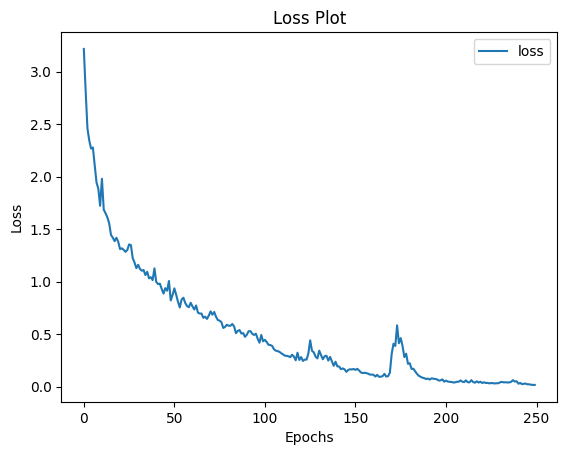

In [12]:
plt.plot(loss_plt, label='loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# test the output caption prediction
def evaluate(image, max_length):
    attention_plot = np.zeros((max_length,attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    img_tensor_val = tf.expand_dims(image,0)
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([FULL_VOCAB.index('<start>')],0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,features,hidden)

        attention_plot[i] = tf.reshape(attention_weights,(-1,)).numpy()

        predicted_id = tf.random.categorical(predictions,1)[0][0].numpy()
        result.append(FULL_VOCAB[predicted_id])

        if FULL_VOCAB[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id],0)

    attention_plot = attention_plot[:len(result),:]
    return result, attention_plot

MOD_PICO_PALETTE = PICO_PALETTE.copy()
MOD_PICO_PALETTE[0] = (0,0,0,0)
def plot_attention(image,result,attention_plot,thresh=0.1):
    spr = image
    fig = plt.figure(figsize=(20,10))
    colormap = ListedColormap(PICO_PALETTE,N=len(PICO_PALETTE))
    alpha_cmap = LinearSegmentedColormap.from_list('rb_cmap',[colorConverter.to_rgba('black',alpha = 1),colorConverter.to_rgba('black',alpha = 0)])

    len_result = len(result)
    col = 8
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l],(8,8))
        # temp_att[temp_att>thresh] = 1
        # temp_att[temp_att<=thresh] = 0
        # all1 = np.where(temp_att==1)
        # all0 = np.where(temp_att==0)
        # temp_att[all1] = 0
        # temp_att[all0] = 1
        # print(temp_att)
        ax = fig.add_subplot(int(len(result) / col) + 1, col, l + 1)
        ax.set_title(result[l])
        ax.imshow(spr.squeeze(),cmap=colormap,vmin=0,vmax=len(MOD_PICO_PALETTE)-1)
        ax.imshow(temp_att,cmap=alpha_cmap)     # 0 - not highlighteed, 1 - highlighted; color shown means attention
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Real label:  a fox standing up with a red and green suit
Predicted label:  a fox standing up with a red and green suit


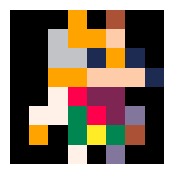

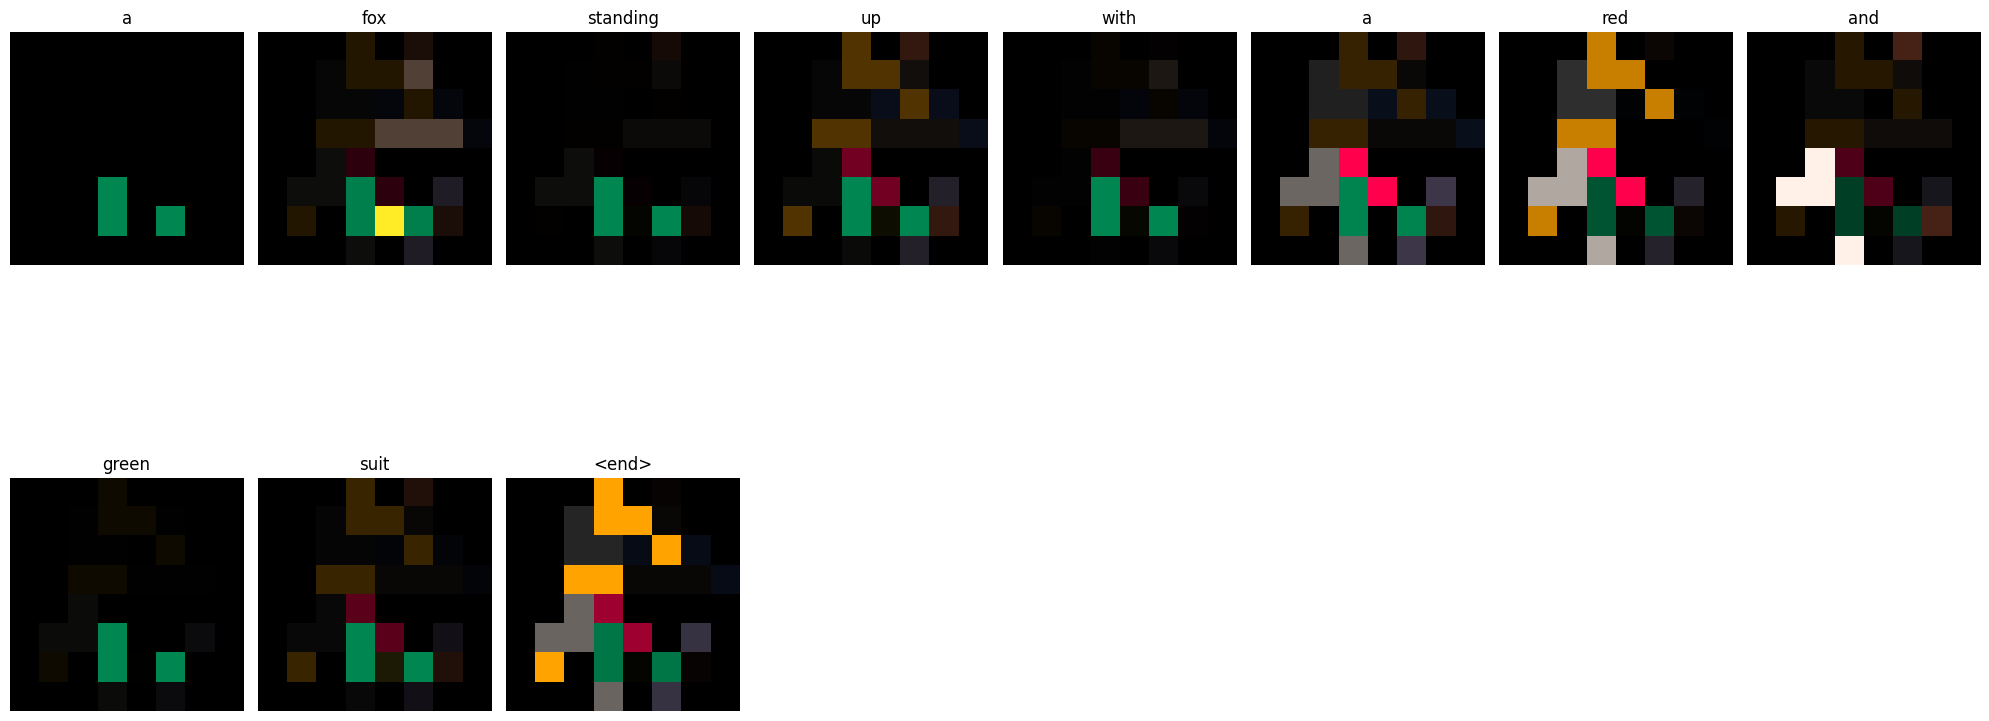

In [14]:
# pick an image
rand_spr_i = np.random.randint(0,len(pico_char_dat))
rand_spr = pico_char_dat[rand_spr_i]
rand_spr_flat = encodeSpr1H(rand_spr).reshape((64,16))

# predict
real_label = pico_char_labels[rand_spr_i]
pred_label, attention_plot = evaluate(rand_spr_flat, max_length=long_desc)
pred_label_str = " ".join(pred_label).replace('<end>','').strip()


# show the image and attention
print('Real label: ',(real_label))
print('Predicted label: ', pred_label_str)
showSprPalette(rand_spr,palette=PICO_PALETTE)
plot_attention(rand_spr, pred_label, attention_plot,0.01)


#### Make new training data from the sprite cutouts

In [15]:
# save the attention and caption sequence for every sprite image

X_cut = []
y_cut = []
with tqdm(total=len(pico_char_dat)) as pbar:
    for si in range(len(pico_char_dat)):
        s = pico_char_dat[si]
        spr_flat = encodeSpr1H(s).reshape((64,16))
        pred_label, attention_plot = evaluate(spr_flat, max_length=long_desc)
        pred_label.insert(0,'<start>')
        # print(' '.join(pred_label))
        pred_label_tok = tok(' '.join(pred_label))
        # print(pred_label_tok)
        pbar.set_description(f'Processing sprite #{si}: {pred_label_tok}')

        # should predict the attention plot of the sprite image from the text before it
        xi = []
        yi = []
        cur_spr = np.zeros((8,8,16))  # beginning sprite (all black)

        for i in range(len(pred_label_tok)):
            if pred_label[i] == '<end>':
                break
            elif pred_label[i] == '<start>':
                continue
            else:
                # get pixels from attention that are 'active'
                hard_attn_plot = attention_plot[i-1].copy()

                attn_spr = np.multiply(hard_attn_plot, spr_flat.transpose())  # should be 16x64 continuous values (between 0-1)
                attn_spr = attn_spr.transpose()
                attn_spr = attn_spr.reshape((8,8,16))

                # set the attention * pixels as the y to predict
                yi.append(attn_spr)

                
                # add the current word token, the current sprite, the entire label embedding, and the token sequence index from the start as input
                xi.append([pred_label_tok[i], cur_spr, pico_char_emb[si], i])   
                # xi.append([GLOVE_DAT[pred_label[i]],cur_spr])  # use glove embedding instead of bad of words embedding

                # apply addition to the current sprite
                cur_spr = cur_spr + attn_spr
                cur_spr = np.clip(cur_spr,0,1)

        X_cut.append(xi)
        y_cut.append(yi)
        
        pbar.update(1)

Processing sprite #99: [1, 4, 139, 83, 136, 17, 9, 7, 4, 139, 55, 136, 4, 139, 83, 136, 17, 46, 7, 101, 32, 2]: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


In [16]:
# show the attention focused sprite cut out pixels
def showCutouts(cutouts, text=None, textArr=None, minmax=False):
    if minmax:
        cmin, cmax = np.min(cutouts), np.max(cutouts)
        print(f"Min: {cmin}, Max: {cmax}")

    fig = plt.figure(figsize=(20,10))
    colormap = ListedColormap(PICO_PALETTE,N=len(PICO_PALETTE))
    alpha_cmap = LinearSegmentedColormap.from_list('rb_cmap',[colorConverter.to_rgba('black',alpha = 1),colorConverter.to_rgba('black',alpha = 0)])

    col = 8
    for l in range(len(cutouts)):
        # print(cutouts[l].shape)
        color_spr = np.argmax(cutouts[l],axis=2)
        temp_att = np.max(cutouts[l],axis=2)

        ax = fig.add_subplot(int(len(cutouts) / col) + 1, col, l + 1)
        if textArr:
            if l == col//2 and text:
                ax.set_title(f"{text.upper()}\n{textArr[l]}")
            else:
                ax.set_title(textArr[l])
        elif text and l == col//2:
            ax.set_title(text)
        ax.imshow(color_spr.squeeze(),cmap=colormap,vmin=0,vmax=len(PICO_PALETTE)-1)  #should show the sprite everytime
        if minmax:
            ax.imshow(temp_att,cmap=alpha_cmap,vmin=cmin,vmax=cmax)     # 0 - not highlighteed, 1 - highlighted; color shown means attention
        else:
            ax.imshow(temp_att,cmap=alpha_cmap)     # 0 - not highlighteed, 1 - highlighted; color shown means attention
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# show the additive sprite input
def showAdditive(adds, thresh=0.05, real=None, start=True, text=None, textArr=None):
    gbs = adds.copy()
    textArr2 = textArr.copy() if textArr else None
    if start:
        gbs.insert(0,np.zeros((8,8,16)))
        if textArr:
            textArr2.insert(0,'[START]')
    gbs = np.array(gbs)
    ghost_build_spr = []
    for g in gbs:
        g[g>thresh] = 1
        g[g<=thresh] = 0
        ghost_build_spr.append(decodeSpr1H(g))

    if real is not None:
        ghost_build_spr.append(real)
        if textArr:
            textArr2.append('[ACTUAL]')

    showMultiSprPalette(ghost_build_spr,textArr=textArr2,text=text,palette=PICO_PALETTE)



/var/folders/5h/0zjb1m296y1gvhtd9q40w4yc0000gn/T/ipykernel_2142/1141000734.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X_dat),np.array(y_dat)


X data shape:  (1040, 2)
y data shape:  (1040, 8, 8, 16)


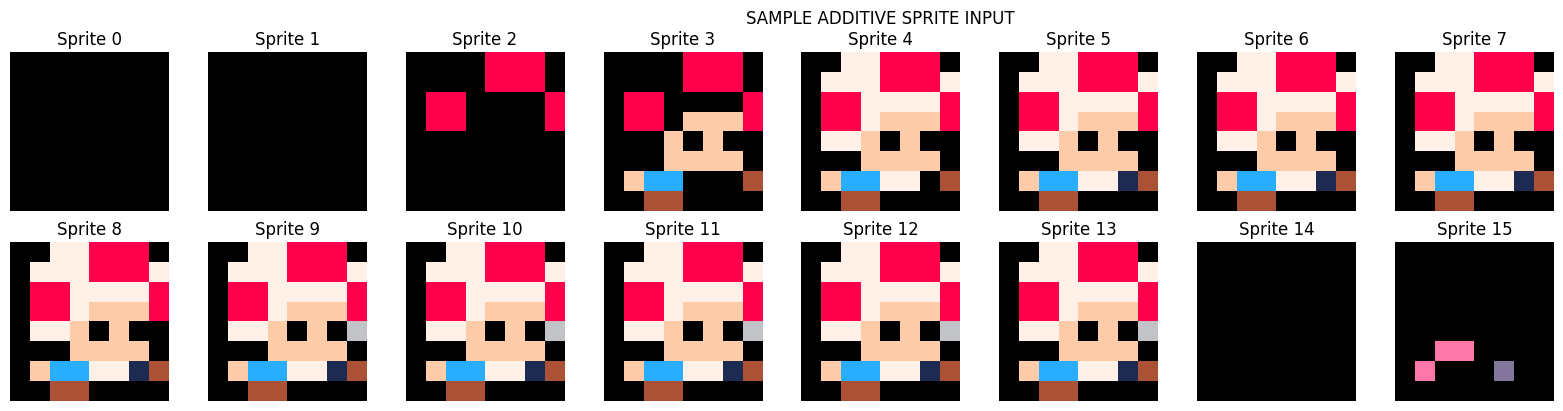

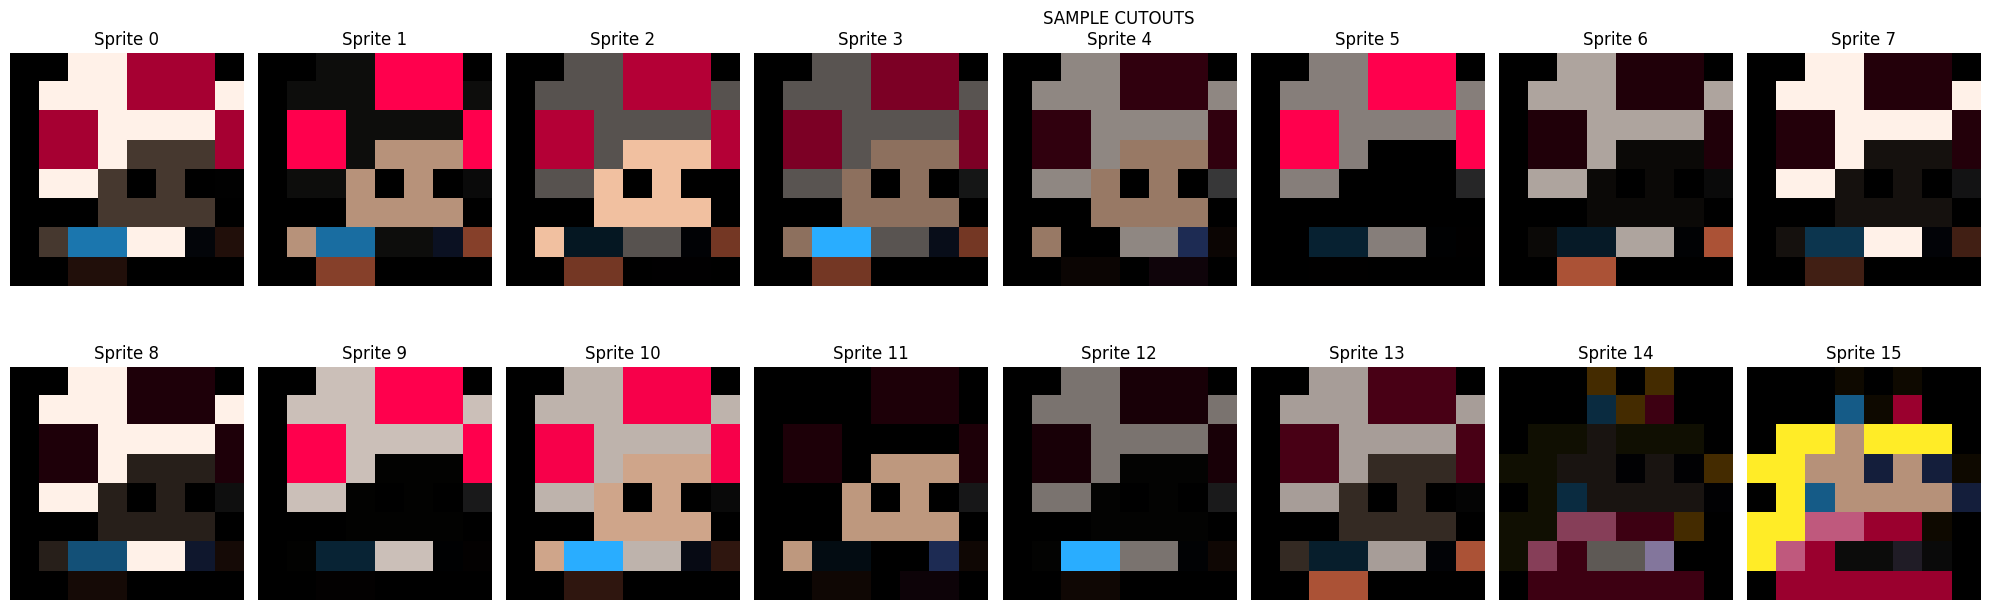

In [17]:
# creates a dataset from the X inputs and y cutouts
def makeDataset(X_cut,y_cut,model_type='kenny'):
    X_dat = []
    y_dat = []

    for i in range(len(X_cut)):

        # each sprite has a set of inputs with their outputs
        # need to add them unassociated
        xs = X_cut[i]
        ys = y_cut[i]

        for j in range(len(xs)):
            if model_type == "kenny":
                X_dat.append(xs[j][:2])
            elif model_type == "cartman":
                X_dat.append(xs[j])
            y_dat.append(ys[j])

    return np.array(X_dat),np.array(y_dat)

X_dat, y_dat = makeDataset(X_cut,y_cut,model_type='kenny')
print("X data shape: ",X_dat.shape)  # should be (num_sprites * seq length, 2) for kenny, (num_sprites * seq length, 4) for cartman
print("y data shape: ",y_dat.shape)  # should be (num_sprites * seq length, 8,8,16)

# show a sample set
samp_idx = random.randint(0,len(X_dat)-16)
showAdditive(X_dat[samp_idx:samp_idx+16,1],text="Sample Additive Sprite Input",textArr=[f"Sprite {i}" for i in range(16)],start=False)
showCutouts(y_dat[samp_idx:samp_idx+16],text="Sample Cutouts",textArr=[f"Sprite {i}" for i in range(16)])

#### Create the South Park model

In [18]:
# DESC: given a slightly constructed sprite, a text token, (optionally: the label embedding, the token sequence index from the start) output the "attention" cutout to add to the sprite
# INPUT: partial sprite: 8x8x16, text token: 1, label embedding: 384x1, token sequence index: 1]
# OUTPUT: attention cutout: 8x8x16
# MODEL TYPES: kenny, cartman, stan, kyle 
#    kenny => uses the partial sprite and text token (basic)
#    cartman => uses the partial sprite, text token, label embedding, and sequence index (most)
class SouthParkModel():
    def __init__(self,spr_size=8,enc_size=384,channels=16,model_type='kenny',lr=0.001):
        self.spr_size = spr_size
        self.enc_size = enc_size
        self.channels = channels
        self.model_type = model_type
        self.lr = lr
        self.units = 64

        # for tim's model
        self.init = tf.keras.initializers.HeNormal(seed=32)

        # create the model
        self.makeModel()

    def makeModel(self):
        # partial constructed sprite input
        sprIn = Input(shape=(self.spr_size,self.spr_size,self.channels))
        sprIn2 = Lambda(lambda x: K.cast(x, dtype='float32'))(sprIn)

        # text token input
        tokIn = Input(shape=(1,))
        tokIn2 = Lambda(lambda x: K.cast(x, dtype='float32'))(tokIn)
        tokIn3 = Dense(self.spr_size*self.spr_size*self.channels)(tokIn2)   
        tokInR = K.reshape(tokIn3,(-1,self.spr_size,self.spr_size,self.channels))

        # (optional) text encoding input
        encIn = Input(shape=(self.enc_size,)),
        encInR = K.reshape(encIn,(-1,8,8,6))     #needs these 2 lines even though they are redundant
        encInF = Flatten()(encInR)
        encInD = Dense(self.spr_size*self.spr_size*self.channels)(encInF)   
        encInR2 = K.reshape(encInD,(-1,self.spr_size,self.spr_size,self.channels))

        # (optional) token sequence index input
        seqIn = Input(shape=(1,))
        seqIn2 = Lambda(lambda x: K.cast(x, dtype='float32'))(seqIn)

        # # concatenate the inputs
        if self.model_type == 'kenny':
            concat = Concatenate(name='kenny-concat')([sprIn2,tokInR])
        elif self.model_type == 'cartman':
            concat = Concatenate(name='cartman-concat')([sprIn,tokIn,encInR2,seqIn2])

        # concat = Concatenate(name='kenny-concat')([sprIn2,tokInR])

        ########     Milk's $2 model    ########
        # x = Dense(256,activation='relu')(concat)
        # # x = Reshape((2,2,64))(x)
        # x = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same', activation='relu')(x)
        # img = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same', activation='softmax')(x)     # should output to a 8x8x16 one-hot encoded image


        ########     Tim's $10 model    ########
        # print(tf.shape(concat))
        x = Flatten()(concat)
        x = Dense(self.units * 2 * 2, activation="relu", kernel_initializer=self.init)(x)
        x = Reshape((2, 2, self.units))(x)

        # upsample to 4x4x16
        x = UpSampling2D()(x)
        x1 = Conv2D(self.units, kernel_size=3, strides=1, padding="same", activation="relu", kernel_initializer=self.init)(x)
        x1 = BatchNormalization()(x1)
        x1 = Conv2D(self.units, kernel_size=3, strides=1, padding="same", activation="relu", kernel_initializer=self.init)(x1)
        x1 = BatchNormalization()(x1)
        x = Add()([x, x1])

        # x1 = Conv2D(self.units, kernel_size=3, strides=1, padding="same", activation="relu", kernel_initializer=self.init)(x)
        # x1 = BatchNormalization()(x1)
        # x1 = Conv2D(self.units, kernel_size=3, strides=1, padding="same", activation="relu", kernel_initializer=self.init)(x1)
        # x1 = BatchNormalization()(x1)
        # x = Add()([x, x1])

        # upsample to 8x8x16
        x = UpSampling2D()(x)
        x2 = Conv2D(self.units, kernel_size=3, strides=1, padding="same", activation="relu", kernel_initializer=self.init)(x)
        x2 = BatchNormalization()(x2)
        x2 = Conv2D(self.units, kernel_size=3, strides=1, padding="same", activation="relu", kernel_initializer=self.init)(x2)
        x2 = BatchNormalization()(x2)
        x = Add()([x, x2])

        # final image output
        img = Conv2D(self.channels, kernel_size=3, padding="same", activation="sigmoid", kernel_initializer=self.init)(x)

        # compile the model
        if self.model_type == 'kenny':
            self.sp_model = Model([sprIn,tokIn], img, name='south_park-KENNY')
        elif self.model_type == 'cartman':
            self.sp_model = Model([sprIn,tokIn,encIn,seqIn], img, name='south_park-CARTMAN')

        self.sp_model = Model([sprIn,tokIn], img, name='south_park-KENNY')

        self.sp_model.compile(optimizer=optimizers.Adam(self.lr), loss='bce', metrics=['accuracy'])
        self.sp_model.summary()

    # import a model from a path
    def importModel(self,model_path):
        self.sp_model = tf.keras.models.load_model(model_path)
        self.sp_model.compile(optimizer=optimizers.Adam(self.lr), loss='bce', metrics=['accuracy'])
        self.sp_model.summary()


    # export the model to a path
    def exportModel(self,model_path):
        self.sp_model.save(model_path,save_format='h5')

    # train the model
    def trainModel(self,X,y,epochs=20,batch_size=16,validation_split=0.05):

        # split up X into the different inputs to convert to numpy arrays
        X1 = np.array([x[1] for x in X])  # the sprites (put it first in the model :P)
        X2 = np.array([x[0] for x in X])  # the tokens
        X2 = np.expand_dims(X2,axis=1)

        print(f"Sprite input shape: {X1.shape}")
        print(f"Text token input shape: {X2.shape}")
        print(f"Output shape: {y.shape}")
        
        return self.sp_model.fit([X1, X2],y,epochs=epochs,batch_size=batch_size,validation_split=validation_split)


south_park_mod = SouthParkModel()

Model: "south_park-KENNY"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 lambda_1 (Lambda)              (None, 1)            0           ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 8, 8, 16)]   0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 1024)         2048        ['lambda_1[0][0]']               
                                                                                   

#### Train the model

Sprite input shape: (1040, 8, 8, 16)
Text token input shape: (1040, 1)
Output shape: (1040, 8, 8, 16)
Epoch 1/20
62/62 [==============================] - 3s 23ms/step - loss: 0.0689 - accuracy: 0.1223 - val_loss: 0.0336 - val_accuracy: 0.2133
Epoch 2/20
62/62 [==============================] - 1s 21ms/step - loss: 0.0141 - accuracy: 0.1995 - val_loss: 0.0128 - val_accuracy: 0.1719
Epoch 3/20
62/62 [==============================] - 1s 19ms/step - loss: 0.0125 - accuracy: 0.1469 - val_loss: 0.0131 - val_accuracy: 0.1770
Epoch 4/20
62/62 [==============================] - 1s 21ms/step - loss: 0.0109 - accuracy: 0.1998 - val_loss: 0.0090 - val_accuracy: 0.1836
Epoch 5/20
62/62 [==============================] - 1s 20ms/step - loss: 0.0093 - accuracy: 0.2219 - val_loss: 0.0087 - val_accuracy: 0.2079
Epoch 6/20
62/62 [==============================] - 1s 22ms/step - loss: 0.0086 - accuracy: 0.2624 - val_loss: 0.0083 - val_accuracy: 0.2377
Epoch 7/20
62/62 [==============================] - 

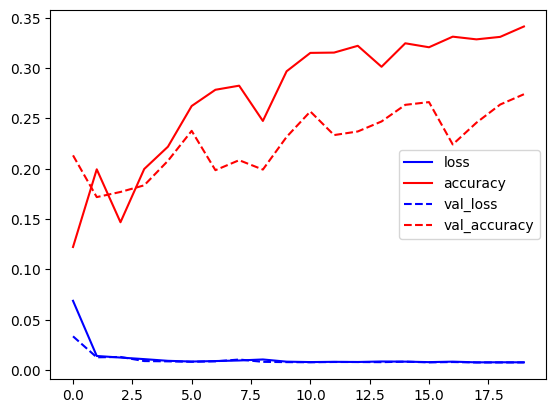

In [19]:
EPOCHS = 20
BATCH_SIZE = 16
VALIDATION_SPLIT = 0.05

# train the model
hist = south_park_mod.trainModel(X_dat,y_dat,epochs=EPOCHS,batch_size=BATCH_SIZE,validation_split=VALIDATION_SPLIT)

# plot the training history
plt.plot(hist.history['loss'], 'b')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_loss'], 'b--')
plt.plot(hist.history['val_accuracy'], 'r--')
plt.legend(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
plt.show()


# save the model
south_park_mod.exportModel('models/south_park_model.h5')

In [20]:
# inference the model to build a sprite based on text
def buildSpr(prompt):
    # tokenize the prompt first
    prompt_tok = tok(prompt,add_start_end=True)
    prompt_tok = np.array(prompt_tok)
    print(prompt_tok)

    # start with a blank sprite
    spr = np.zeros((1,8,8,16))   # additive sprite

    # iterate through each token and generate a sprite
    attn_spr_set = []
    build_spr_set = [spr]
    for t in prompt_tok:
        if t == 0 or t == 2:  # ending token (pad or end)
            break
        t = np.expand_dims(t,axis=0)
        # get the sprite from the model
        attn_spr = south_park_mod.sp_model.predict([spr,t],verbose=False)[0]
        attn_spr = np.squeeze(spr,axis=0)
        attn_spr_set.append(attn_spr)

        # add the sprite to the final sprite
        spr = spr.squeeze() + attn_spr
        spr = np.clip(cur_spr,0,1)
        spr = np.expand_dims(spr,axis=0)
        build_spr_set.append(spr)

    # return the final sprite argmaxed
    return np.argmax(spr,axis=-1), np.array(attn_spr_set).squeeze(), np.array(build_spr_set).squeeze()  # should return a 8x8 sprite

[  1   4 139  83 136  17  46   7 101  32   2   0   0   0   0   0   0   0
   0   0   0   0   0]
cur spr (in): (11, 8, 8, 16)
tokens (in): 10
attn (out): (10, 8, 8, 16)


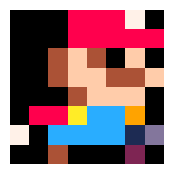

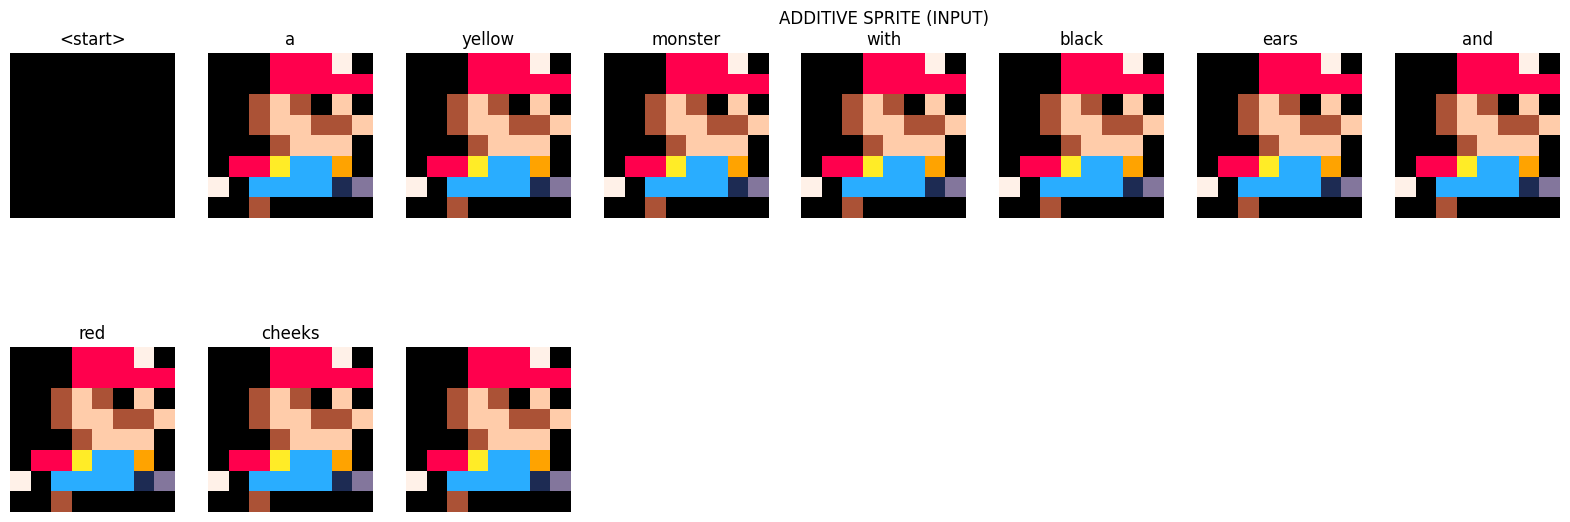

Min: 0.0, Max: 0.4599525136873126


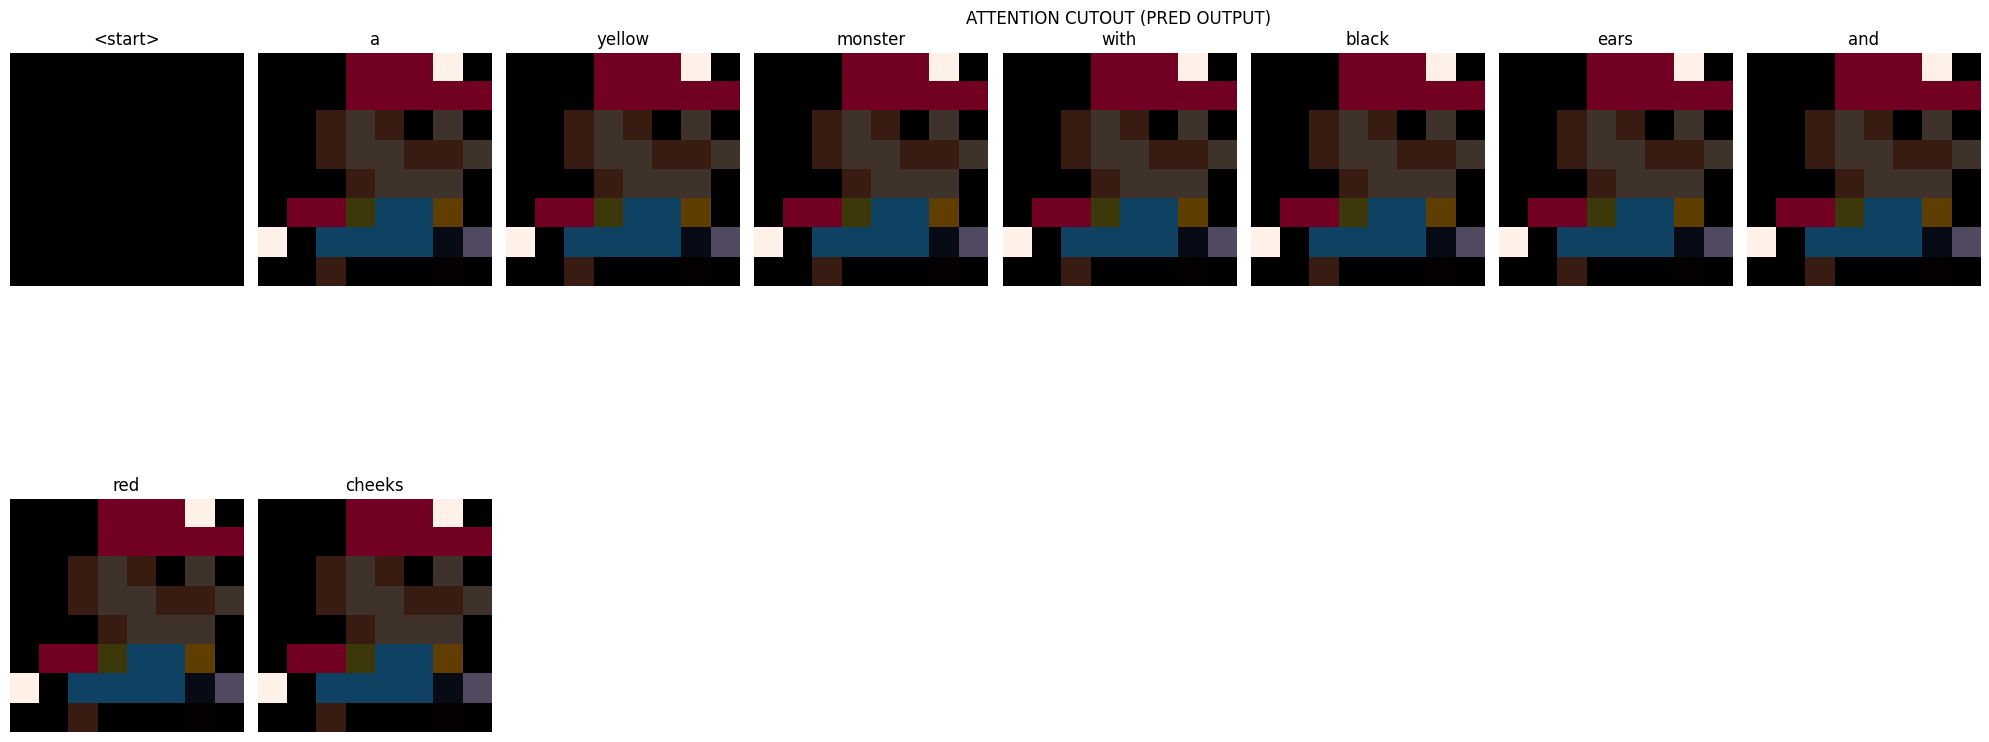

In [28]:
# test output on pikachu
prompt = "a yellow monster with black ears and red cheeks"
splt_prompt = ['<start>'] + prompt.split(" ")
pika_mod_pred, pika_attn, pika_build = buildSpr(prompt)


print("cur spr (in):",pika_build.shape)
print("tokens (in):",len(splt_prompt))
print("attn (out):",pika_attn.shape)


# show the final sprite
showSprPalette(pika_mod_pred)

# show the build sprites
showAdditive(pika_build,text='Additive Sprite (input)', textArr=splt_prompt, start=False)

# show the attention sprites
showCutouts(pika_attn,text='Attention Cutout (pred output)', textArr=splt_prompt, minmax=True)

[  1   4  19 131 120 132   2   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]
cur spr (in): (7, 8, 8, 16)
tokens (in): 6
attn (out): (6, 8, 8, 16)


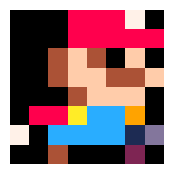

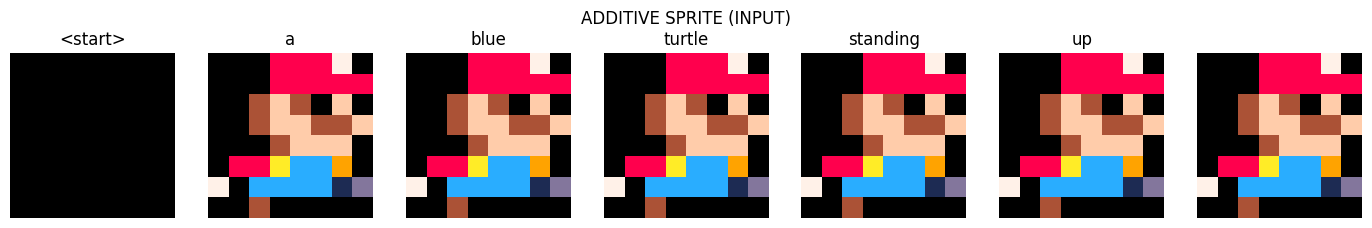

Min: 0.0, Max: 0.4599525136873126


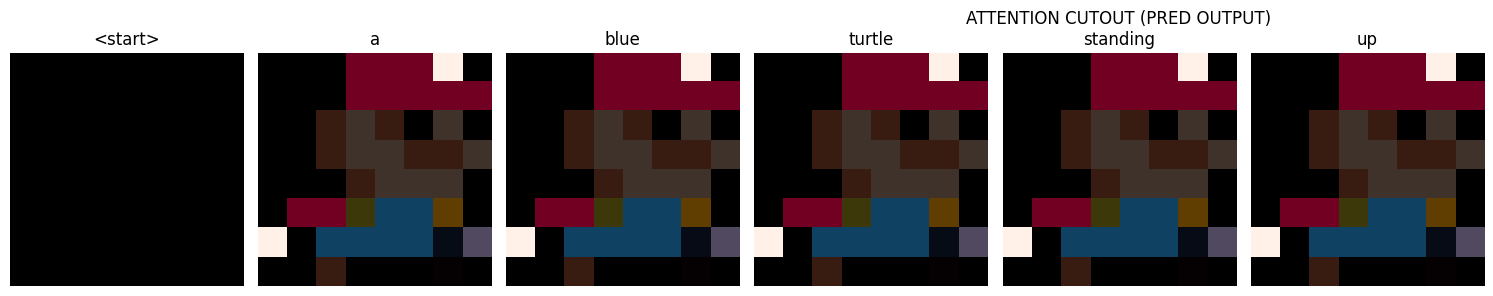

In [27]:
# test output on fake character
prompt2 = "a blue turtle standing up"
splt_prompt2 = ['<start>'] + prompt2.split(" ")
fake_mod_pred, fake_attn, fake_build = buildSpr(prompt2)

print("cur spr (in):",fake_build.shape)
print("tokens (in):",len(splt_prompt2))
print("attn (out):",fake_attn.shape)

# show the final sprite
showSprPalette(fake_mod_pred)

# show the build sprites
showAdditive(fake_build,text='Additive Sprite (input)', textArr=splt_prompt2, start=False)

# show the attention sprites
showCutouts(fake_attn,text='Attention Cutout (pred output)', textArr=splt_prompt2, minmax=True)



#### Sanity Check

In [ ]:
SANITY_CHECK = False

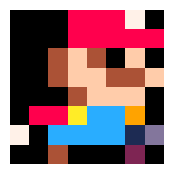

(8, 2)
(8, 8, 8, 16)


/var/folders/5h/0zjb1m296y1gvhtd9q40w4yc0000gn/T/ipykernel_2142/3349137010.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xi = np.array(xi)


In [22]:
if SANITY_CHECK:
    s = pico_char_dat[0]
    showSprPalette(s,palette=PICO_PALETTE)
    spr_flat = encodeSpr1H(s).reshape((64,16))
    pred_label, attention_plot = evaluate(spr_flat, max_length=long_desc)

    pred_label.insert(0,'<start>')

    # should predict the attention plot of the sprite image from the text before it
    xi = []
    yi = []
    cur_spr = np.zeros((8,8,16))  # beginning sprite (all black)

    for i in range(len(pred_label)):
        if pred_label[i] == '<end>':
            break
        elif pred_label[i] == '<start>':
            continue
        else:
            # get pixels from attention that are 'active'
            # hard_attn_plot = np.resize(attention_plot[i],(8,8))
            hard_attn_plot = attention_plot[i-1].copy()
            # hard_attn_plot[hard_attn_plot>=attn_thresh] = 1
            # hard_attn_plot[hard_attn_plot<attn_thresh] = 0
            # hard_attn_plot = np.repeat(hard_attn_plot,16).reshape((64,16))
            # print(hard_attn_plot)


            # print(hard_attn_plot.shape)  # should be 64x16
            attn_spr = np.multiply(hard_attn_plot, spr_flat.transpose())  # should be 16x64 continuous values (between 0-1)
            # print(attn_spr[10,:]) #show yellow
            attn_spr = attn_spr.transpose()
            # print(attn_spr.shape)  # should be 64x16
            attn_spr = attn_spr.reshape((8,8,16))
            # print(attn_spr.shape)  # should be 8x8x16

            # set as the y to predict
            yi.append(attn_spr)

            # apply addition to the current sprite

            # xi.append([GLOVE_DAT[pred_label[i]],cur_spr])
            xi.append([pred_label[i],cur_spr])

            cur_spr = cur_spr + attn_spr
            cur_spr = np.clip(cur_spr,0,1)

    xi = np.array(xi)
    yi = np.array(yi)

    print(xi.shape)
    print(yi.shape)
                

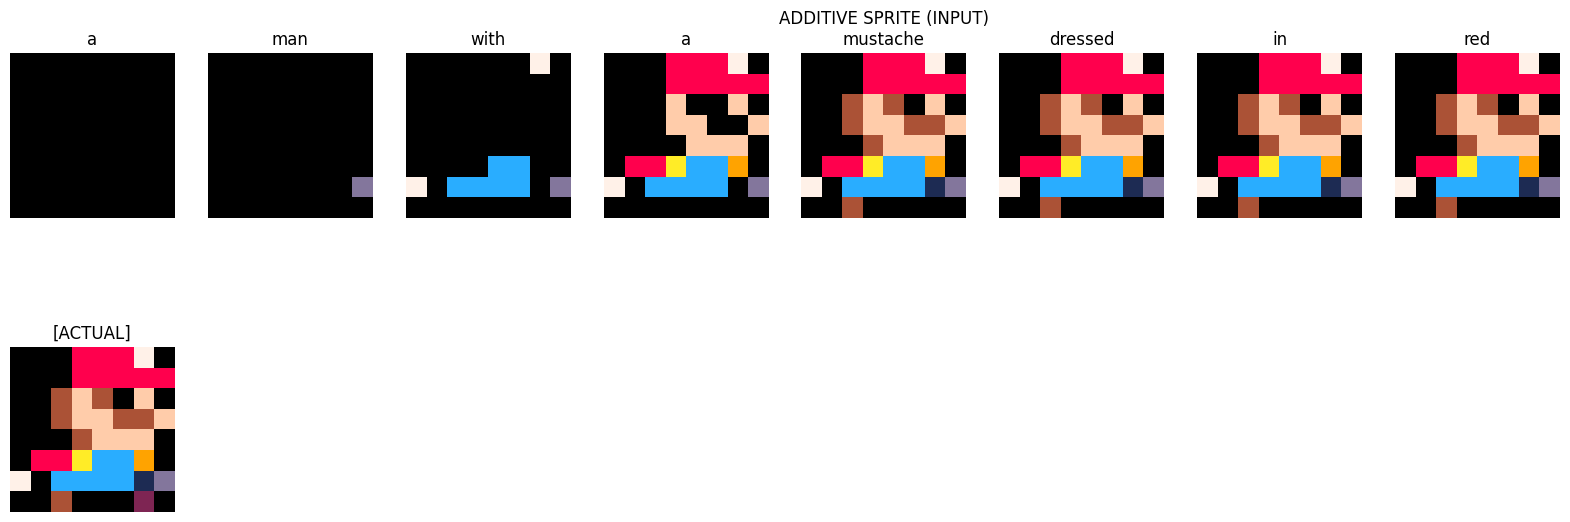

Min: 0.0, Max: 0.28764718770980835


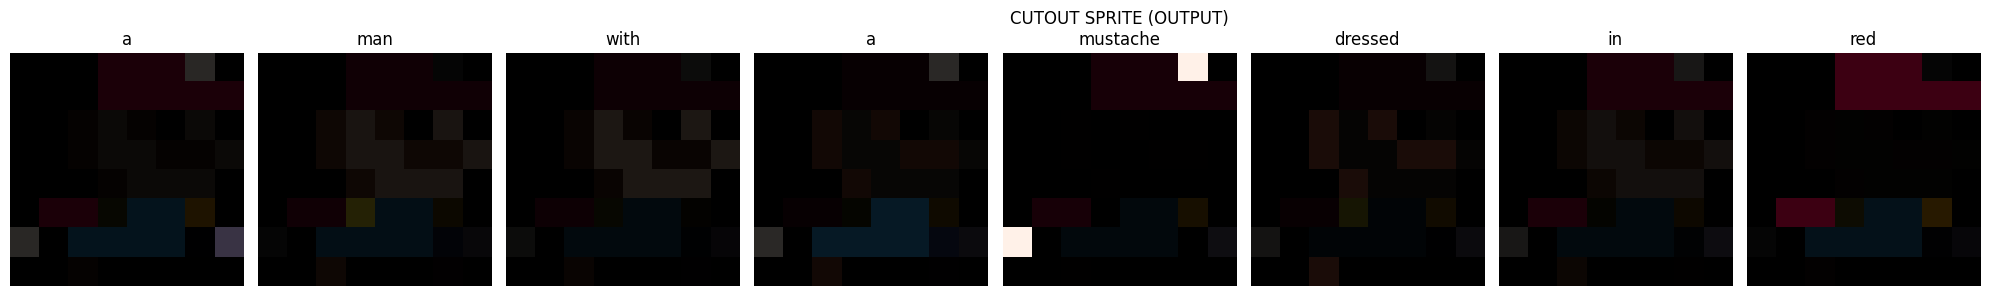

In [23]:
# show the cut out and the growing sprite
if SANITY_CHECK:
    showAdditive([x[1] for x in xi], real=s, thresh=0.05, text='Additive Sprite (input)', textArr=[x for x in xi[:,0]], start=False)
    showCutouts(yi, text='Cutout Sprite (output)', textArr=[x for x in xi[:,0]], minmax=True)

# showMultiSprPalette([decodeSpr1H(x) for x in xi[:,1]],textArr=[f"step: {s}" for s in range(len(xi[:,]))],palette=PICO_PALETTE)
# showMultiSprPalette([decodeSpr1H(y) for y in yi],text='Prediction Attention',textArr=[x for x in xi[:,0]],palette=PICO_PALETTE)

======  X1 (spr)  ======
(1, 8, 8, 16)
[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  ...

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0

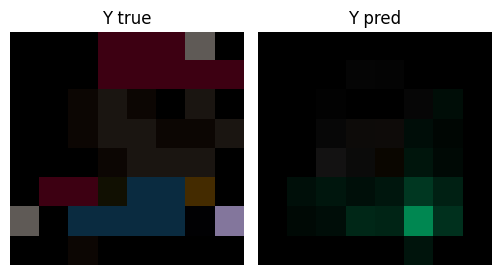

In [25]:
# look at the training data
if SANITY_CHECK:

    # split up X into the different inputs to convert to numpy arrays
    X1 = np.array([X_dat[0][1]])  # the sprites (put it first in the model :P)
    X2 = np.array([X_dat[0][0]])  # the tokens
    X2 = np.expand_dims(X2,axis=1)

    print("======  X1 (spr)  ======")
    print(X1.shape)
    print(X1)

    print("======  X2 (token)  ======")
    print(X2.shape)
    print(X2)

    print("======  y (attn)  ======")
    y = np.array([y_dat[0]])
    print(y.shape)
    print(y)

    pred = south_park_mod.sp_model.predict([X1,X2])
    print("======  pred (attn)  ======")
    print(pred.shape)
    print(pred)

    showCutouts([y.squeeze(),pred.squeeze()], textArr=['Y true','Y pred'])